## Fraud detection- by using Autoencoders and t-sne

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [25]:
dataset = pd.read_excel("Automation.xls")
dataset.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [26]:
dataset.shape


(65535, 11)

In [27]:
# Get numeric columns names

numeric_columns_names = dataset.select_dtypes("number").columns

print('Number of numeric features:', numeric_columns_names.shape)
print(numeric_columns_names)

Number of numeric features: (8,)
Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')


In [28]:
#numeric_df
numeric_df = dataset[[name for name in numeric_columns_names]]


# Numeric - Numeric Correlation

<AxesSubplot:>

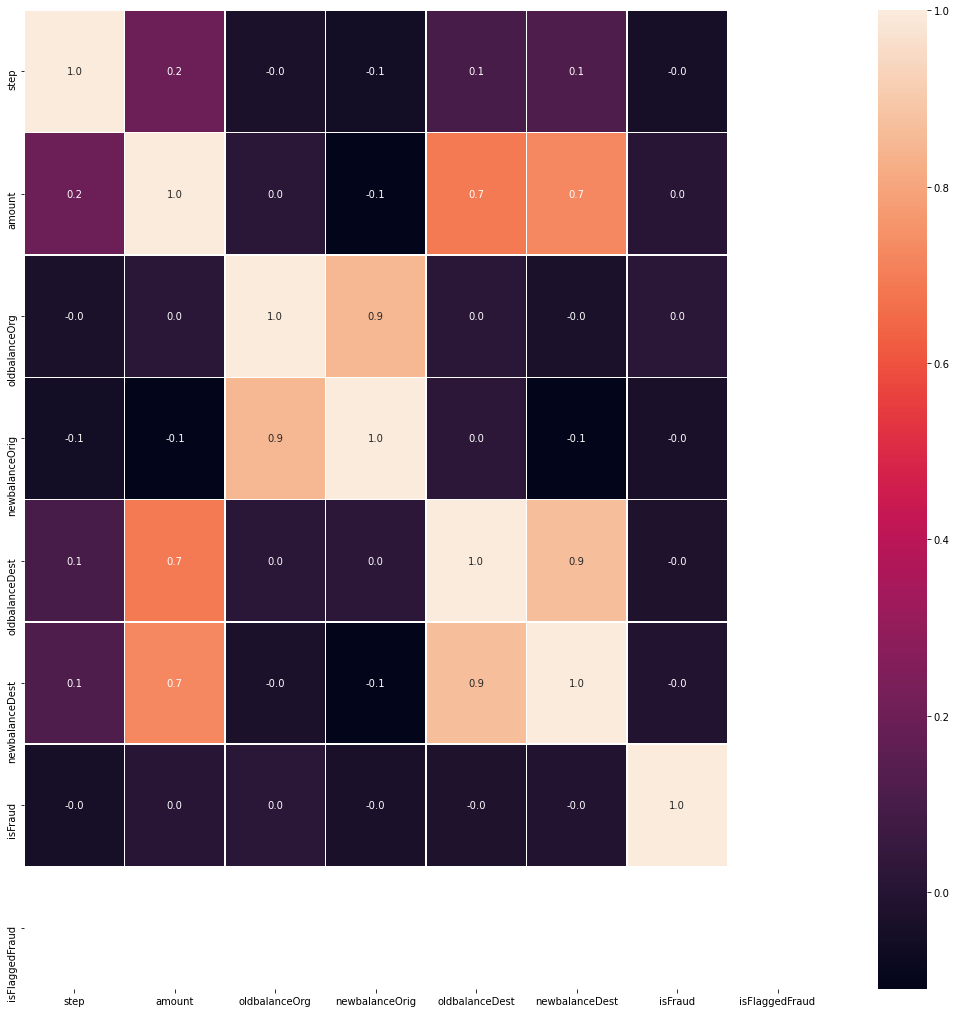

In [29]:
f, ax = plt.subplots(figsize = (18, 18))

corrMatt = numeric_df.corr(method='spearman') #we use spearman since its knows to work with features that dont have normal distribution

sns.heatmap(corrMatt, annot = True, linewidth = 0.5, fmt = '.1f', ax = ax)

In [30]:
X = numeric_df.drop('isFraud', axis=1) # remove the isFraud column for unsupervised learning
y = numeric_df['isFraud']

In [31]:
X_train, X_val, _, _ = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((52428, 7), (13107, 7))

### Using a Autoencoder

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. It is composed of a enconding part responsable to compress the data and a decoder to reconstruct the data.



In [32]:
ss = StandardScaler()
X_tscaled = ss.fit_transform(X_train.values)
X_train = pd.DataFrame(X_tscaled, columns=X_train.columns, index=X_train.index)

X_vscaled = ss.transform(X_val.values)
X_val = pd.DataFrame(X_vscaled, columns=X_val.columns, index=X_val.index)

In [33]:
# input
inp = Input(shape=(X.shape[1],))

# Encoder
x = Dense(100, activation='relu')(inp)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
# Decoder
x = Dense(50, activation='tanh')(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='tanh')(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
## output
output = Dense(X.shape[1], activation='relu')(x)

autoencoder = Model(inp, output)

lr = 0.0001
epochs = 300
adam = Adam(lr=lr, decay=(lr/epochs))

autoencoder.compile(optimizer=adam, loss="mean_squared_error",metrics=["accuracy"])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

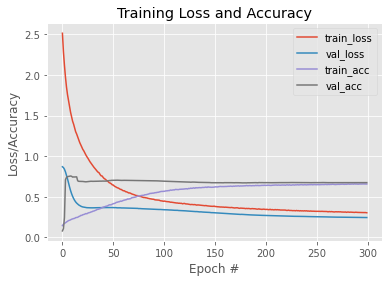

In [34]:
history = autoencoder.fit(X_train.values, X_train.values,validation_data=(X_val.values, X_val.values), batch_size=2048, epochs=epochs,shuffle=True, verbose=0)
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 300), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 300), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 300), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 300), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [70]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])
encoder.add(autoencoder.layers[3])
encoder.add(autoencoder.layers[4])
encoder.add(autoencoder.layers[5])
encoder.add(autoencoder.layers[6])

decoder = Sequential()

decoder.add(autoencoder.layers[7])
decoder.add(autoencoder.layers[8])
decoder.add(autoencoder.layers[9])
decoder.add(autoencoder.layers[10])
decoder.add(autoencoder.layers[11])
decoder.add(autoencoder.layers[12])
decoder.add(autoencoder.layers[13])


In [71]:
encoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
Total params: 6,450
Trainable params: 6,150
Non-trainable params: 300
_________________________________________________

In [72]:
X_tt = encoder.predict(X_train)
X_tt.shape

(52428, 50)

In [73]:
X_dt = decoder.predict(X_tt)
X_dt.shape

(52428, 7)

In [74]:
X_tt = encoder.predict(X_train)
X_dt = decoder.predict(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_train.columns, index=X_train.index)

reconstruction_score = []
for idx in X_train.index:
    score = mean_squared_error(X_train.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_train.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()
rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index


In [75]:
pred_train = pd.DataFrame(index=X_train.index)
pred_train['fraud'] = 0
for x in top_scores_idx:
    pred_train['fraud'].loc[x] = 1
    
pred_train

,fraud
60526,0
18173,0
6676,0
46721,0
36433,0
...,...
37811,0
44499,0
31846,0
41400,0


Text(0, 0.5, 'Number of samples')

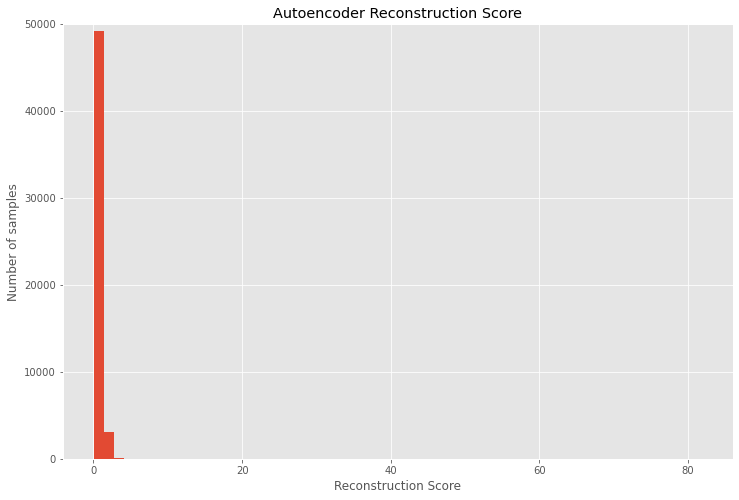

In [76]:
plt.figure(figsize=(12, 8))
rc_scores['reconstruction_score'].hist(bins=60)
plt.ylim(0, 50000)
plt.title('Autoencoder Reconstruction Score')
plt.xlabel('Reconstruction Score')
plt.ylabel('Number of samples')

In [77]:
X_tt = encoder.predict(X_val)
X_dt = decoder.predict(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_val.columns, index=X_val.index)

reconstruction_score = []
for idx in X_val.index:
    score = mean_squared_error(X_val.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_val.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()
rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index


In [78]:
pred_val = pd.DataFrame(index=X_val.index)
pred_val['fraud'] = 0
for x in top_scores_idx:
    pred_val['fraud'].loc[x] = 1

In [79]:
pred_val

,fraud
38447,0
3890,0
63407,0
10161,0
9950,0
...,...
47365,0
306,1
39737,0
33677,0


### Tsne

Using TSNE we visualize Autoencoder compressed data distribution.



In [80]:
X_enc_tsne = encoder.predict(X_val)
X_enc_tsne = pd.DataFrame(X_enc_tsne, index=X_val.index)

X_enc_tsne['isFraud'] = pred_val
ok_sample = X_enc_tsne[X_enc_tsne['isFraud'] == 0].sample(2000)
df_fraud = X_enc_tsne[X_enc_tsne['isFraud'] == 1]
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.values
y_tsne = df_tsne["isFraud"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

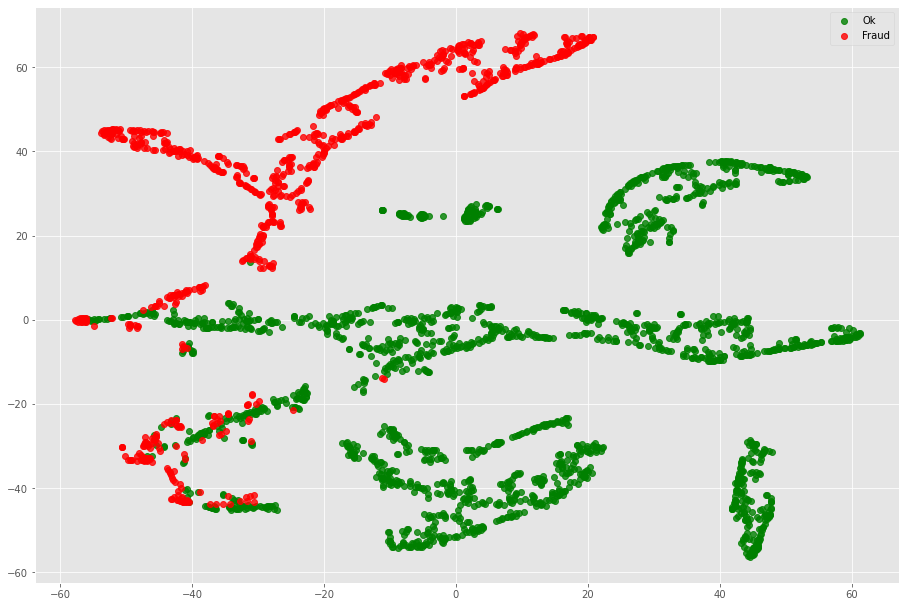

In [81]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth=1, alpha=.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth=1, alpha=.8, label='Fraud')
ax.legend(loc='best')

In [82]:
pred_val.value_counts()


fraud
0        12235
1          872
dtype: int64

In [83]:
X_enc_tsne = encoder.predict(X_train)
X_enc_tsne = pd.DataFrame(X_enc_tsne, index=X_train.index)

X_enc_tsne['isFraud'] = pred_train
ok_sample = X_enc_tsne[X_enc_tsne['isFraud'] == 0].sample(4000)
df_fraud = X_enc_tsne[X_enc_tsne['isFraud'] == 1]
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.values
y_tsne = df_tsne["isFraud"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

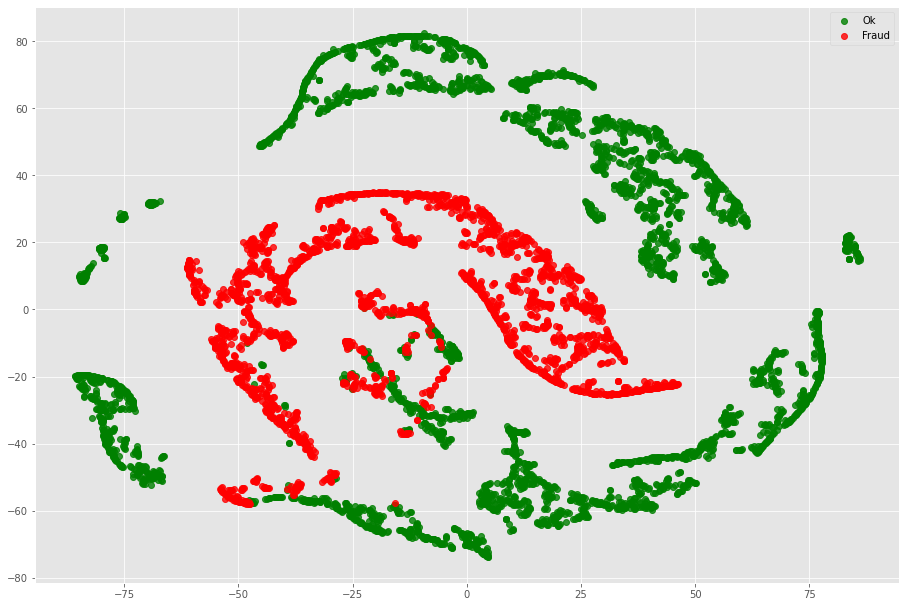

In [84]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth=1, alpha=.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth=1, alpha=.8, label='Fraud')
ax.legend(loc='best')

In [85]:
pred_train.value_counts()


fraud
0        49940
1         2488
dtype: int64

In [86]:
labeled_fraud_1=pred_train.copy()
labeled_fraud_2=pred_val.copy()

In [87]:
labeled_fraud_1.index.name = 'index'
labeled_fraud_2.index.name = 'index'
labeled_fraud_1

,fraud
index,
60526,0
18173,0
6676,0
46721,0
36433,0
...,...
37811,0
44499,0
31846,0


In [88]:
labeled_fraud_2

,fraud
index,
38447,0
3890,0
63407,0
10161,0
9950,0
...,...
47365,0
306,1
39737,0


In [89]:
labeled_fraud= pd.concat([labeled_fraud_1, labeled_fraud_2], ignore_index=True, sort=False)
labeled_fraud.index.name = 'index'
labeled_fraud.value_counts()

fraud
0        62175
1         3360
dtype: int64

In [90]:
labeled_fraud.columns.names=['Fraud']


In [91]:
dataset.index.name = 'index'
dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
index,,,,,,,,,,,
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
65530,9,CASH_IN,50529.41,C1132444754,6493984.64,6544514.05,C1956477953,308079.99,0.00,0,0
65531,9,CASH_IN,58429.17,C2059144571,6544514.05,6602943.22,C1137371968,4724976.11,6392871.31,0,0
65532,9,CASH_IN,114387.37,C687420794,6602943.22,6717330.59,C135254299,122030.09,7642.72,0,0


In [92]:
merge_pd = pd.merge(dataset,labeled_fraud, how='inner', on ='index')

In [93]:
merge_pd["fraud"].value_counts()

0    62175
1     3360
Name: fraud, dtype: int64

In [94]:
### moving fraud to the last column
cols = list(merge_pd.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('fraud')) #Remove fraud from list
merge_pd = merge_pd[cols+['fraud']] #moving the fraud to the last column
merge_pd.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,fraud
index,,,,,,,,,,,,
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0


In [95]:
first=merge_pd.loc[merge_pd['fraud'] == 1, 'nameOrig']

In [102]:
type_of_tra=merge_pd.loc[merge_pd['fraud'] == 1, 'type']
type_of_tra.value_counts()

PAYMENT     1386
CASH_OUT     983
CASH_IN      664
TRANSFER     299
DEBIT         28
Name: type, dtype: int64

In [96]:
second=merge_pd.loc[merge_pd['isFraud'] == 1, 'nameOrig']

In [97]:
first=list(first.index.values)  # this will always work in pandas
second=list(second.index.values)  # this will always work in pandas
